In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model


import dill

import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
with open('tiffs.pkl', 'rb') as in_strm:
    all_info = dill.load(in_strm)

In [4]:
x_train = all_info[0]
x_test = all_info[1]
y_train = all_info[2]
y_test = all_info[3]

In [5]:
def flatten(matrix):
    vector = np.reshape(matrix, (matrix.shape[0], matrix.shape[1] * matrix.shape[2], matrix.shape[3]))
    return vector

In [6]:
x_train = flatten(x_train)
print(x_train.shape)
x_test = flatten(x_test)
print(x_test.shape)

(35000, 1024, 3)
(5479, 1024, 3)


In [7]:
def zero_mean(matrix):
    m = matrix.mean(axis=1)
    return matrix - m[:, np.newaxis]

In [8]:
x_train = zero_mean(x_train)
x_test = zero_mean(x_test)

In [9]:
x_train_red = x_train[:,:,0]
x_train_green = x_train[:,:,1]
x_train_blue = x_train[:,:,2]
x_test_red = x_test[:,:,0]
x_test_green = x_test[:,:,1]
x_test_blue = x_test[:,:,2]

In [10]:
pca = PCA(n_components=400, whiten=True)
pca.fit(x_train_red)
pca_reds = pca.transform(x_train_red)
pca = PCA(n_components=400, whiten=True)
pca.fit(x_train_green)
pca_greens = pca.transform(x_train_green)
pca = PCA(n_components=400, whiten=True)
pca.fit(x_train_blue)
pca_blues = pca.transform(x_train_blue)
pca_x_train = np.array([pca_reds, pca_greens, pca_blues])
pca_x_train = np.reshape(pca_x_train, (pca_x_train.shape[1], pca_x_train.shape[2], 3))
print(pca_x_train.shape)

(35000, 400, 3)


In [11]:
pca = PCA(n_components=400, whiten=True)
pca.fit(x_test_red)
pca_test_reds = pca.transform(x_test_red)
pca = PCA(n_components=400, whiten=True)
pca.fit(x_test_green)
pca_test_greens = pca.transform(x_test_green)
pca = PCA(n_components=400, whiten=True)
pca.fit(x_test_blue)
pca_test_blues = pca.transform(x_test_blue)
pca_x_test = np.array([pca_test_reds, pca_test_greens, pca_test_blues])
pca_x_test = np.reshape(pca_x_test, (pca_x_test.shape[1], pca_x_test.shape[2], 3))
print(pca_x_test.shape)

(5479, 400, 3)


In [12]:
pca_x_train = np.reshape(pca_x_train, (pca_x_train.shape[0], 20, 20, pca_x_train.shape[2]))

In [13]:
pca_x_test = np.reshape(pca_x_test, (pca_x_test.shape[0], 20, 20, pca_x_test.shape[2]))

In [14]:
imgplot = plt.imshow(pca_x_train[0])

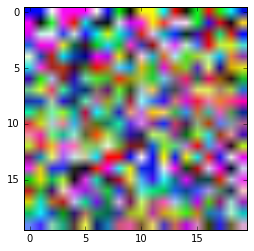

In [15]:
plt.show()

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                input_shape=(20, 20, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                    optimizer='adam',
                    metrics=['accuracy'])

model.save('keras_starter.h5')  # creates a HDF5 file 'my_model.h5'

model.fit(pca_x_train, y_train, batch_size=128, epochs=2, verbose=1, 
          validation_data=(pca_x_test, y_test))

from sklearn.metrics import fbeta_score

p_valid = model.predict(pca_x_test, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))


Train on 35000 samples, validate on 5479 samples
Epoch 1/2
35000/35000 [==============================] - 71s - loss: 0.2888 - acc: 0.8971 - val_loss: 0.2568 - val_acc: 0.9056
Epoch 2/2
35000/35000 [==============================] - 79s - loss: 0.2636 - acc: 0.9050 - val_loss: 0.2551 - val_acc: 0.9056
[[0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 1]
 [0 1 0 ..., 1 0 1]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 1 ..., 0 0 1]
 [0 1 0 ..., 0 0 1]]
[[ 0.00918124  0.1210169   0.18933488 ...,  0.18772833  0.00349244
   0.28832939]
 [ 0.00809131  0.1134732   0.19040395 ...,  0.19044548  0.00298986
   0.28769737]
 [ 0.00718285  0.10041349  0.17053345 ...,  0.17422637  0.00255455
   0.28571278]
 ..., 
 [ 0.0038435   0.08397554  0.16676448 ...,  0.15945606  0.001386
   0.25577721]
 [ 0.0059987   0.10523947  0.16460006 ...,  0.17617032  0.00233407
   0.26905024]
 [ 0.00937901  0.1147673   0.18724889 ...,  0.17853144  0.00374764
   0.27868032]]
0.681146766741


In [ ]:
import theano